# Evaluating Nightshade

## Imports

In [1]:
import torch
from eval_nightshade import NightshadeEvaluator
from nightshade import Nightshade
from perturbation_methods import fgsm_penalty, pgd_penalty, nightshade_penalty
from data_process import get_dataset, get_poisoning_candidates, get_poisoned_dataset, create_mixed_dataset
from PIL import Image
import gc
import glob
import pickle
import numpy as np
import os
from diffusers import StableDiffusionPipeline

%load_ext autoreload
%autoreload 2
%matplotlib inline
SD_MODEL_ID = 'runwayml/stable-diffusion-v1-5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# shared_pipeline = StableDiffusionPipeline.from_pretrained(
#     SD_MODEL_ID,
#     safety_checker=None,
#     torch_dtype=torch.float16,
# ).to(device)
# shared_pipeline.set_progress_bar_config(disable=True)

## Part 1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluator = NightshadeEvaluator(device=device)

methods = {
    'fgsm': fgsm_penalty,
    'pgd': pgd_penalty,
    'original': nightshade_penalty
}


results = {}
poisoned_imgs = {}
for name, method in methods.items():
    nightshade = Nightshade(target_concept=None, device=device, penalty_method=method, sd_pipeline=shared_pipeline)
    original_img = Image.open('test_images/dog.jpg')
    poisoned_img = nightshade.generate(original_img, target_concept='cat')
    poisoned_imgs[name] = poisoned_img

    results[name] = {
        'visual_metrics': evaluator.evaluate_perturbation(original_img, poisoned_img),
        'embedding_metrics': evaluator.evaluate_embedding_shift(original_img, poisoned_img, 'cat')
    }

    del nightshade
    gc.collect()
    torch.cuda.empty_cache()



In [ ]:
for name, result in results.items():
    print(f"Results for {name}:")
    print(f"Visual Metrics: {result['visual_metrics']}")
    print(f"Embedding Metrics: {result['embedding_metrics']}")
    print()
    # Display the poisoned image
    display(poisoned_imgs[name])

## Part 2

In [ ]:
# get a list of poisoning candidates
clean_dataset = get_dataset('annotations/captions_train2014.json', 'train2014', 20000)
poisoning_candidates = get_poisoning_candidates(clean_dataset, 'dog', 300)

In [ ]:
from tqdm.notebook import tqdm
candidate_files = glob.glob("poisoning_candidates/pickle/dog_*.p")
candidates = [pickle.load(open(f, 'rb')) for f in candidate_files]
methods = {
    'fgsm': fgsm_penalty,
    'pgd': pgd_penalty,
    'original': nightshade_penalty,
}
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for name, method in methods.items():
    output_dir = f'poisoned_images/{name}'
    nightshade = Nightshade(target_concept=None, device=device, penalty_method=method, sd_pipeline=shared_pipeline)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(f"{output_dir}/pickle"):
        os.makedirs(f"{output_dir}/pickle")
    if not os.path.exists(f"{output_dir}/images"):
        os.makedirs(f"{output_dir}/images")
    for candidate in tqdm(candidates, desc=f'Poisoning with {name} method', total=len(candidates)):
        
        original_img = Image.fromarray(candidate['img'])
        poisoned_img = nightshade.generate(original_img, target_concept='cat')
        poisoned_data = {
            'img': np.array(poisoned_img),
            'text': candidate['text']
        }
        pickle.dump(poisoned_data, open(f"{output_dir}/pickle/{name}_{candidate['image_id']}.p", 'wb'))
        poisoned_img.save(f"{output_dir}/images/{name}_{candidate['image_id']}.jpg")
    print(f'Saved {len(candidates)} poisoned images for {name} method in {output_dir}')
    del nightshade
    gc.collect()
    torch.cuda.empty_cache()


### Train Stable Diffusion on each sample

In [2]:
# del shared_pipeline
# gc.collect()
# torch.cuda.empty_cache()

num_poisoned = [300]
methods = {
    'fgsm': fgsm_penalty,
    'pgd': pgd_penalty,
    'original': nightshade_penalty
}

poisoned_datasets = {}
clean_dataset = get_dataset('annotations/captions_train2014.json', 'train2014', 10000)
for name, method in methods.items():
    for num in num_poisoned:
        poisoned_dataset = get_poisoned_dataset(f'poisoned_images/{name}/pickle', limit=num)
        poisoned_datasets[f"{name}_{num}"] = poisoned_dataset

# mixed_datasets = {}
# for name, poisoned_dataset in poisoned_datasets.items():
#     mixed_datasets[name] = create_mixed_dataset(clean_dataset, poisoned_dataset)

Processing unique images:   0%|          | 0/82783 [00:00<?, ?it/s]

Loaded 10000 unique image entries
Loaded 300 poisoned entries from poisoned_images/fgsm/pickle
Loaded 300 poisoned entries from poisoned_images/pgd/pickle
Loaded 300 poisoned entries from poisoned_images/original/pickle


In [3]:
from train_sd import train_model
# for name, poisoned_dataset in poisoned_datasets.items():
name= 'pgd_300'
poisoned_dataset = poisoned_datasets[f'{name}']
mixed_dataset = create_mixed_dataset(clean_dataset, poisoned_dataset)
train_model(mixed_dataset, f'output_models/{name}', epochs=5, batch_size=2)

Mixing datasets:   0%|          | 0/300 [00:00<?, ?it/s]

/home/zabibeau/Spring2025/MachineLearning2/nightshade-ml/data_process.py:214: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '66164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, col] = row[col]


✅ Created mixed dataset with 300/10000 poisoned entries (3.00% poisoned).
Using device: cuda, dtype: torch.float16
VAE device: cuda:0, dtype: torch.float16
UNet device: cuda:0, dtype: torch.float32
Text encoder device: cuda:0, dtype: torch.float16


Epoch 1/5:   0%|          | 0/5000 [00:00<?, ?it/s]

Pixel values: shape=torch.Size([2, 3, 512, 512]), device=cuda:0, dtype=torch.float16


Epoch 2/5:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ Training complete. Model saved to output_models/pgd_300


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🔄 Loading LoRA weights from output_models/fgsm_300/lora_adapter...
✅ LoRA applied!
✨ Generating samples for prompt: 'a photo of a dog'...


  0%|          | 0/30 [00:00<?, ?it/s]

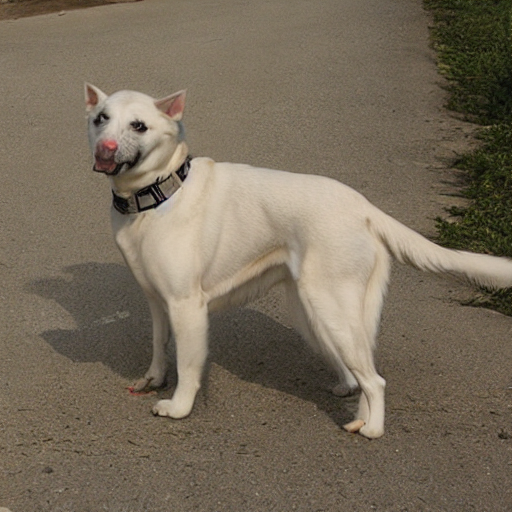

  0%|          | 0/30 [00:00<?, ?it/s]

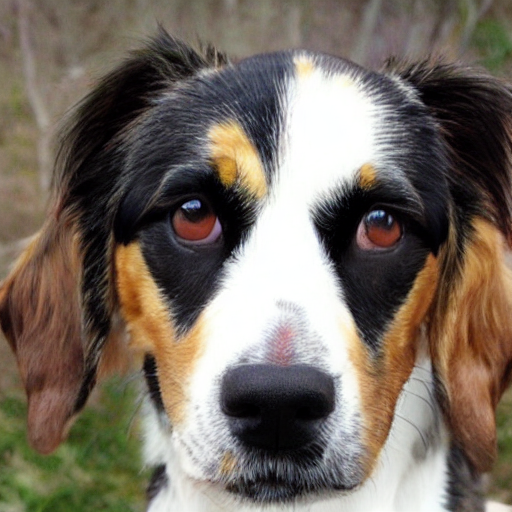

  0%|          | 0/30 [00:00<?, ?it/s]

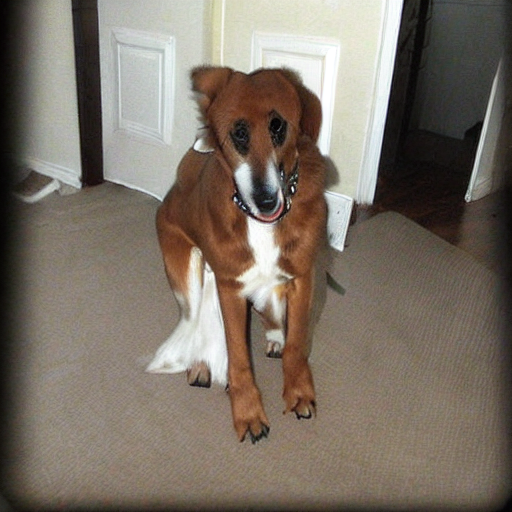

  0%|          | 0/30 [00:00<?, ?it/s]

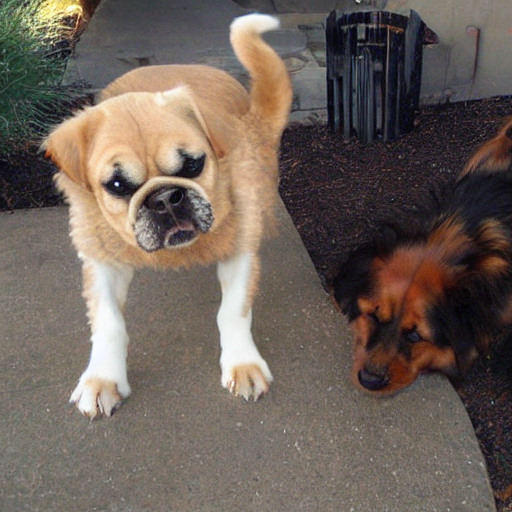

  0%|          | 0/30 [00:00<?, ?it/s]

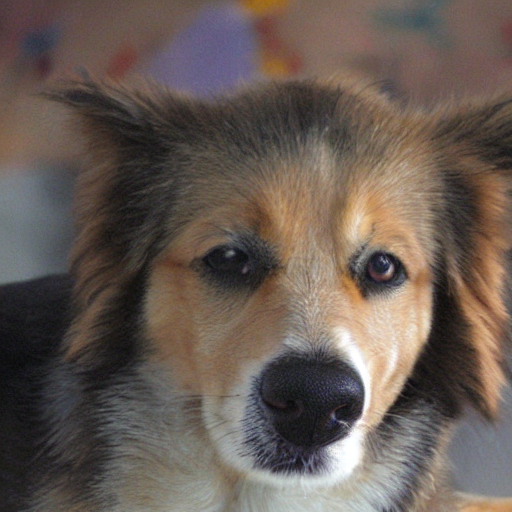

  0%|          | 0/30 [00:00<?, ?it/s]

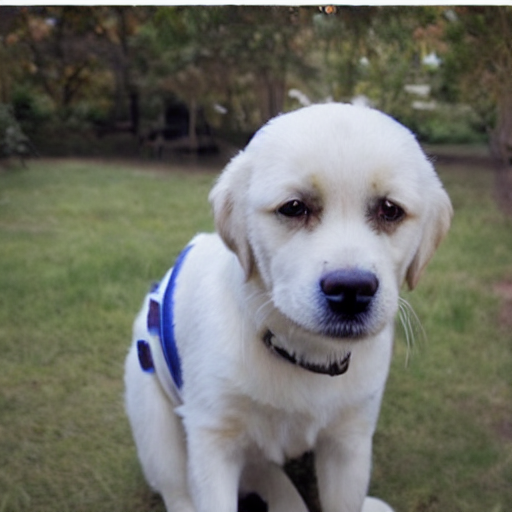

  0%|          | 0/30 [00:00<?, ?it/s]

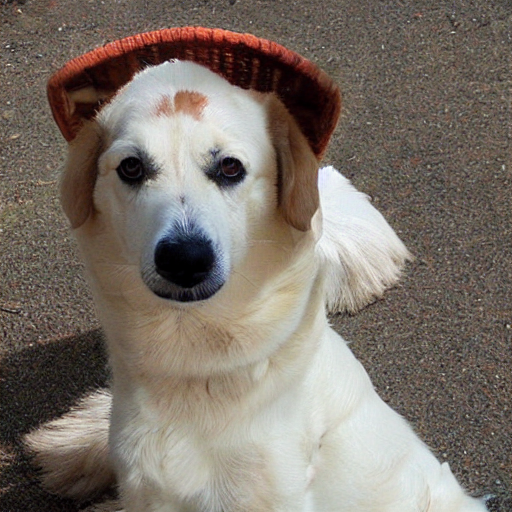

  0%|          | 0/30 [00:00<?, ?it/s]

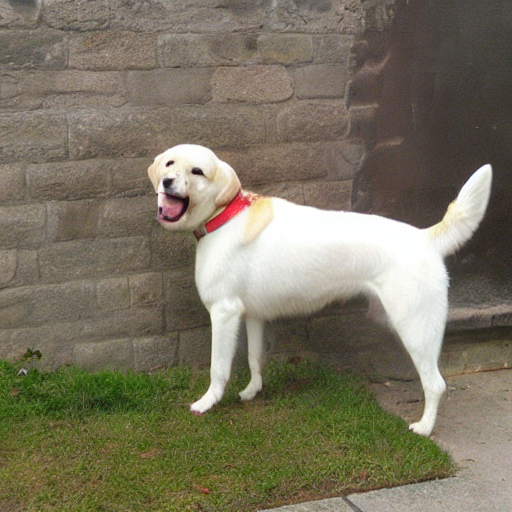

  0%|          | 0/30 [00:00<?, ?it/s]

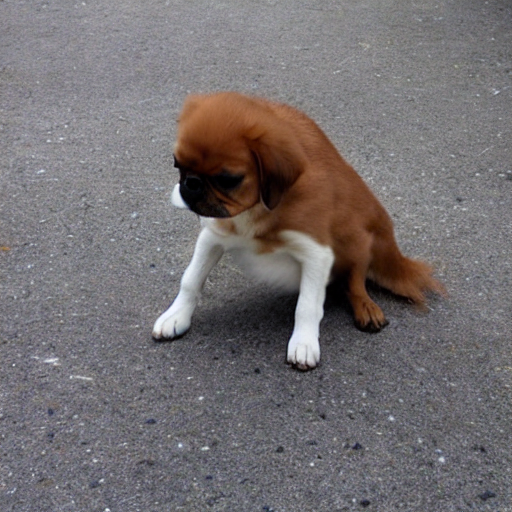

  0%|          | 0/30 [00:00<?, ?it/s]

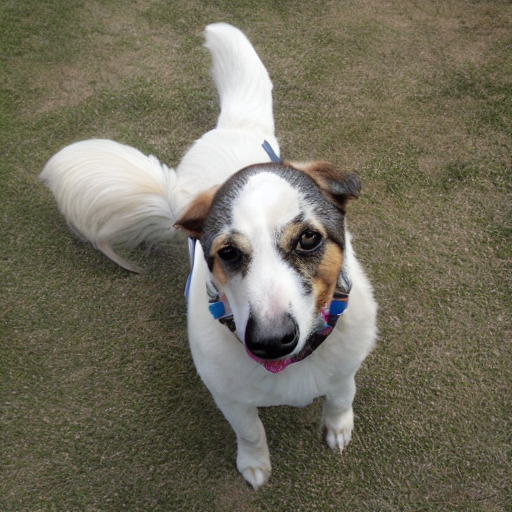

In [7]:
# infer_lora.py

import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, set_peft_model_state_dict
from PIL import Image
import os

torch.backends.cudnn.benchmark = True

# --- Configs ---
PENALTY = 'fgsm'
LORA_WEIGHTS_PATH = f"output_models/{PENALTY}_300/lora_adapter"  # <-- path to your trained LoRA
BASE_MODEL_PATH = "runwayml/stable-diffusion-v1-5"  # <-- your base model
OUTPUT_DIR = "generated_samples"
PROMPT = "a photo of a dog"  # <-- change your test prompt
NUM_INFERENCE_STEPS = 30
GUIDANCE_SCALE = 7.5

# --- Load Models ---

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the full Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL_PATH,
    torch_dtype=torch.float16,
    safety_checker=None,  # disables NSFW checker if you want
)

pipe.to(device)

# Now load your LoRA
print(f"🔄 Loading LoRA weights from {LORA_WEIGHTS_PATH}...")
unet = pipe.unet
unet = get_peft_model(unet, LoraConfig(
    r=4,  # match your training r value
    target_modules=["to_k", "to_q", "to_v", "proj_out"],  # match your training target modules
    lora_alpha=16,
    lora_dropout=0.1,
))

# Load the actual weights
lora_state_dict = torch.load(os.path.join(LORA_WEIGHTS_PATH, "pytorch_lora_weights.bin"), map_location="cpu")
set_peft_model_state_dict(unet, lora_state_dict)

print("✅ LoRA applied!")

# --- Inference ---

os.makedirs(OUTPUT_DIR, exist_ok=True)

generator = torch.Generator(device=device).manual_seed(42)  # set seed for reproducibility

print(f"✨ Generating samples for prompt: '{PROMPT}'...")
for i in range(10):
    with torch.autocast("cuda"):
        image = pipe(
            prompt=PROMPT,
            num_inference_steps=NUM_INFERENCE_STEPS,
            guidance_scale=GUIDANCE_SCALE,
            generator=generator,
        ).images[0]

    # Save image
    save_path = os.path.join(OUTPUT_DIR, f"{PENALTY}_{i}.png")
    image.save(save_path)
    display(image)

